# Pre-TP2: Grafos en neuro

## 1. Introducción
El análisis de la topología de grafos (es decir, redes) es un área de investigación que atañe a diferentes campos de estudio. Para ejemplificar el uso de grafos nos enfocaremos en el los datos obtenidos en el trabajo de Tagliazucchi y colaboradores (2013) que busca relacionar cambios en la modularidad de las redes construidas a partir de la señal de resonancia
magnética funcional (fMRI) con los distintos estadíos del sueño.

## 2. Objetivos
Familiarizarse con la generación de grafos que representen un conjunto de datos. Visualizar, manipular y comparar distintos grafos. Calcular parámetros básicos de un grafo, y compararlos con modelos de redes random, small world y scale-free.

## 3. Estructuctura de los datos
En la carpeta DataSujetos se encuentran los archivos separados por cada sujeto y estadio del sueño bajo la siguiente notación [Estadio del sueño]_[Número de sujeto].csv. Para cada sujeto y estadío de sueño encontraremos una matriz de correlaciones de tamaño 116x116 con las correlaciones entre las señales BOLD de 116 regiones cerebrales. Además se incluyen los nombres y coordenadas de las 116 regiones en un archivo apar- te: aalextendedwithCoords.csv. Estas regiones están definidas a partir del atlas Automatic Anatomical Labeling (AAL)

In [28]:
# !wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip -O ../../data/raw/DataSujetos.zip
# !unzip -q ../../data/raw/DataSujetos.zip -d ../../data/interim/
# !wget -q https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws -O ../../data/raw/aal_extended_withCoords.csv

In [43]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

In [50]:
def density_to_th(W, d):
    n=W.shape[0]
    max_links = (n*(n-1))//2
    print(max_links)
    tril_idx = np.tril_indices(n,-1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*d)]

## 4. Preprocesamiento de los datos
- Cargar el dataset con los datos para cada sujeto y los nombres y coordenadas de las regiones cerebrales a las que se les registró la actividad.

In [2]:
files = os.listdir('../../data/interim/DataSujetos/')
print(files[0:5])

['N3_suj18.csv', 'N2_suj8.csv', 'N3_suj8.csv', 'N3_suj9.csv', 'N2_suj9.csv']


In [27]:
sujetos_dfs = []

for file in files:
    df_temp = pd.read_csv('../../data/interim/DataSujetos/' + file, header=None)
    df_temp['file'] = file
    df_temp[['estado_sueno', 'sujeto']] = df_temp['file'].str.split('_', expand=True)
    df_temp['sujeto'] = df_temp['sujeto'].str.replace('.csv', '').str.replace('suj', '')
    sujetos_dfs.append(df_temp)

df = pd.concat(sujetos_dfs, axis=0, ignore_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,file,estado_sueno,sujeto
0,1.00000,0.75228,0.59672,0.61720,0.61036,0.58281,0.62356,0.60070,0.48458,0.42477,...,0.36404,0.41587,0.37399,0.52954,0.59884,0.48292,0.098455,N3_suj18.csv,N3,18
1,0.75228,1.00000,0.43057,0.57711,0.46849,0.45001,0.42769,0.51553,0.39334,0.36685,...,0.47406,0.51675,0.44855,0.59525,0.75812,0.61522,0.143240,N3_suj18.csv,N3,18
2,0.59672,0.43057,1.00000,0.78695,0.71494,0.62041,0.88456,0.67340,0.63665,0.46685,...,0.28807,0.30319,0.23167,0.37021,0.39687,0.41879,0.269630,N3_suj18.csv,N3,18
3,0.61720,0.57711,0.78695,1.00000,0.60188,0.60783,0.77913,0.77403,0.52327,0.44301,...,0.31306,0.46552,0.44312,0.55917,0.52748,0.54166,0.153890,N3_suj18.csv,N3,18
4,0.61036,0.46849,0.71494,0.60188,1.00000,0.80111,0.70464,0.62453,0.83012,0.70528,...,0.31729,0.34996,0.27957,0.39880,0.47443,0.42913,0.205490,N3_suj18.csv,N3,18


In [61]:
RegionsNames = pd.read_csv("../../data/raw/aal_extended_withCoords.csv", header=None, index_col=0)
RegionsNames.head()

,1,2,3,4,5,6,7
0,,,,,,,
1,Precentral_L,2001,Central,L,-39,-6,51
2,Precentral_R,2002,Central,R,41,-8,52
3,Frontal_Sup_L,2101,Frontal,L,-18,35,42
4,Frontal_Sup_R,2102,Frontal,R,22,31,44
5,Frontal_Sup_Orb_L,2111,Frontal,L,-17,47,-13


- Reportar cuántos sujetos y cuántos estados de sueño se observan en el conjunto de datos.

In [30]:
df.groupby(['estado_sueno'], as_index=False).agg({"sujeto": "nunique"})

,estado_sueno,sujeto
0,N1,18
1,N2,18
2,N3,18
3,W,18


- `W` hace referencia al estado `wake` (despierto) del sujeto y 18 sujetos para esta condición.
- Hay tres estados del sueño (`N1`, `N2` & `N3`) y 18 sujetos por cada estado del sueño.

## 5. Manipulación de datos

- Graficar la matriz de correlaciones entre regiones (es decir, la "matriz de adyacencia pesada") para el `sujeto 2` de la condición despierto ("Wake")

In [34]:
df_sujeto_2 = df[(df['sujeto'] == '2') & (df['estado_sueno'] == 'W')]
df_sujeto_2 = df_sujeto_2.reset_index(drop=True)
df_sujeto_2 = df_sujeto_2.drop(['estado_sueno', 'sujeto', 'file'], axis=1)
df_sujeto_2.head()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
0,1.000000,0.931250,-0.36596,-0.037262,-0.38320,-0.52531,0.22055,0.55746,-0.42691,-0.37738,...,0.65505,0.67698,0.61761,0.72113,0.73791,0.61358,0.39207,0.52388,0.73016,0.624770
1,0.931250,1.000000,-0.36434,-0.047821,-0.39816,-0.51714,0.19599,0.53922,-0.41087,-0.35586,...,0.65411,0.66391,0.62397,0.70520,0.71338,0.61552,0.42667,0.56555,0.71042,0.578120
2,-0.365960,-0.364340,1.00000,0.805290,0.86969,0.91718,0.77668,0.29545,0.88109,0.91498,...,-0.51444,-0.66186,-0.54153,-0.65471,-0.71359,-0.66347,-0.15066,-0.29798,-0.70964,-0.432760
3,-0.037262,-0.047821,0.80529,1.000000,0.71369,0.74156,0.78621,0.67376,0.71059,0.78149,...,-0.30766,-0.44407,-0.33264,-0.34509,-0.35186,-0.47497,-0.22905,-0.13609,-0.29878,-0.055818
4,-0.383200,-0.398160,0.86969,0.713690,1.00000,0.88927,0.59852,0.18166,0.90790,0.89803,...,-0.54662,-0.68150,-0.46798,-0.65440,-0.68123,-0.71640,-0.27918,-0.26101,-0.63446,-0.288370


In [39]:
matAdyacPesada = df_sujeto_2.values
n = matAdyacPesada.shape[0]
matAdyacPesada -= np.diag(np.ones(n))

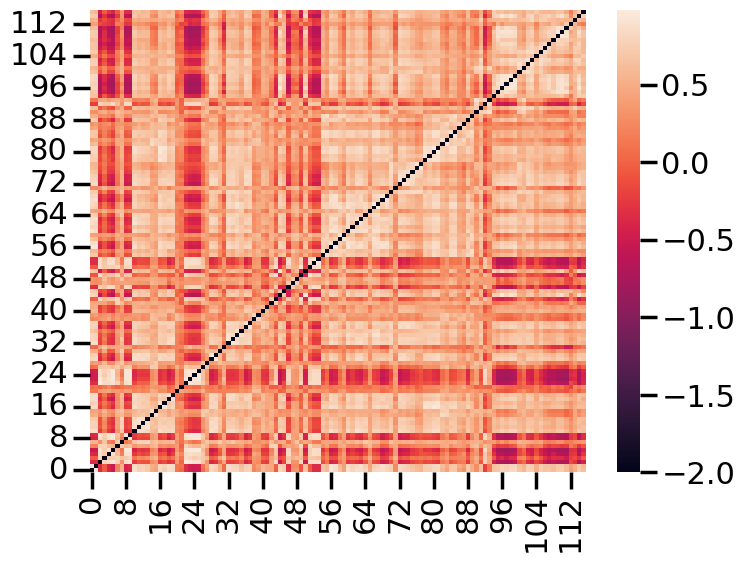

In [46]:
sns.heatmap(matAdyacPesada)
plt.xlim(0,n)
plt.ylim(0,n)
plt.show()

- Seleccionar un umbral de correlación entre regiones: Transformar dicha matriz de adyacencia pesada a una matriz de adyacencia binaria $A_{i,j}$ que represente una una densidad de enlaces $\delta=0.08$. ¿Cuál es el valor de umbral de correlación entre pares de regiones que tuvo que utilizar?

In [54]:
densidad=0.08
thWake=density_to_th(matAdyacPesada, densidad)
print(thWake)

6670
0.77997


In [56]:
matAdyacNoPesada = (matAdyacPesada>=thWake)

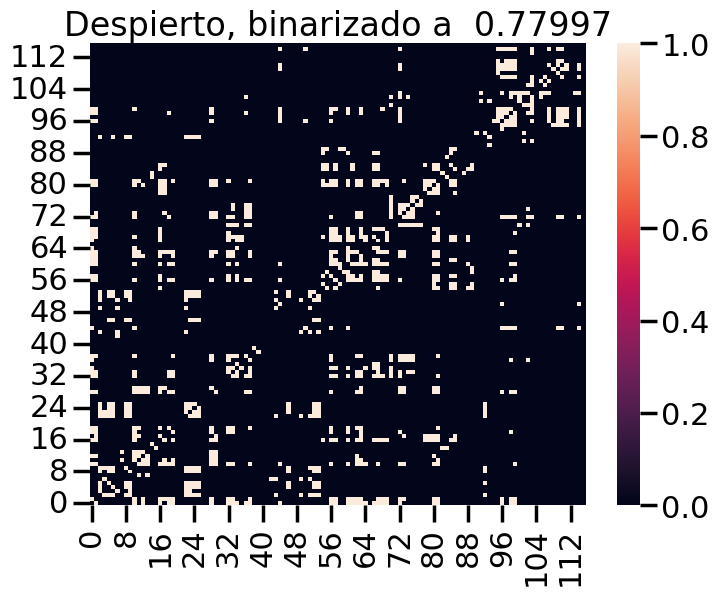

In [57]:
sns.heatmap(matAdyacNoPesada)
plt.xlim(0,n)
plt.ylim(0,n)
plt.title(f'Despierto, binarizado a  {thWake}')
plt.show()

- Utilizando $A_{i,j}$, obtener el grafo resultante $G$ y la lista de enlaces de dicho grafo.

In [74]:
G = nx.from_numpy_array(matAdyacNoPesada)

In [71]:
G.is_directed()

False

In [75]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115))

In [76]:
G.edges()

EdgeView([(0, 1), (0, 10), (0, 12), (0, 16), (0, 18), (0, 19), (0, 28), (0, 32), (0, 33), (0, 34), (0, 36), (0, 37), (0, 44), (0, 56), (0, 57), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 66), (0, 67), (0, 68), (0, 69), (0, 72), (0, 80), (0, 81), (0, 96), (0, 98), (0, 99), (1, 10), (1, 12), (1, 16), (1, 17), (1, 18), (1, 19), (1, 28), (1, 32), (1, 33), (1, 37), (1, 56), (1, 57), (1, 60), (1, 61), (1, 62), (1, 63), (1, 67), (1, 68), (1, 69), (1, 72), (1, 73), (1, 80), (1, 81), (1, 96), (1, 98), (1, 99), (2, 3), (2, 4), (2, 5), (2, 8), (2, 9), (2, 22), (2, 23), (2, 24), (2, 25), (2, 43), (2, 49), (2, 51), (2, 52), (2, 53), (2, 92), (3, 6), (3, 9), (3, 22), (3, 23), (4, 5), (4, 8), (4, 9), (4, 22), (4, 23), (4, 24), (4, 25), (4, 46), (4, 52), (4, 53), (5, 8), (5, 9), (5, 22), (5, 23), (5, 24), (5, 25), (5, 46), (5, 52), (5, 53), (5, 92), (6, 42), (6, 43), (6, 49), (6, 51), (7, 11), (7, 13), (8, 9), (8, 22), (8, 23), (8, 24), (8, 25), (8, 46), (8, 52), (8, 53), (8, 92), (9, 22), (9, 2

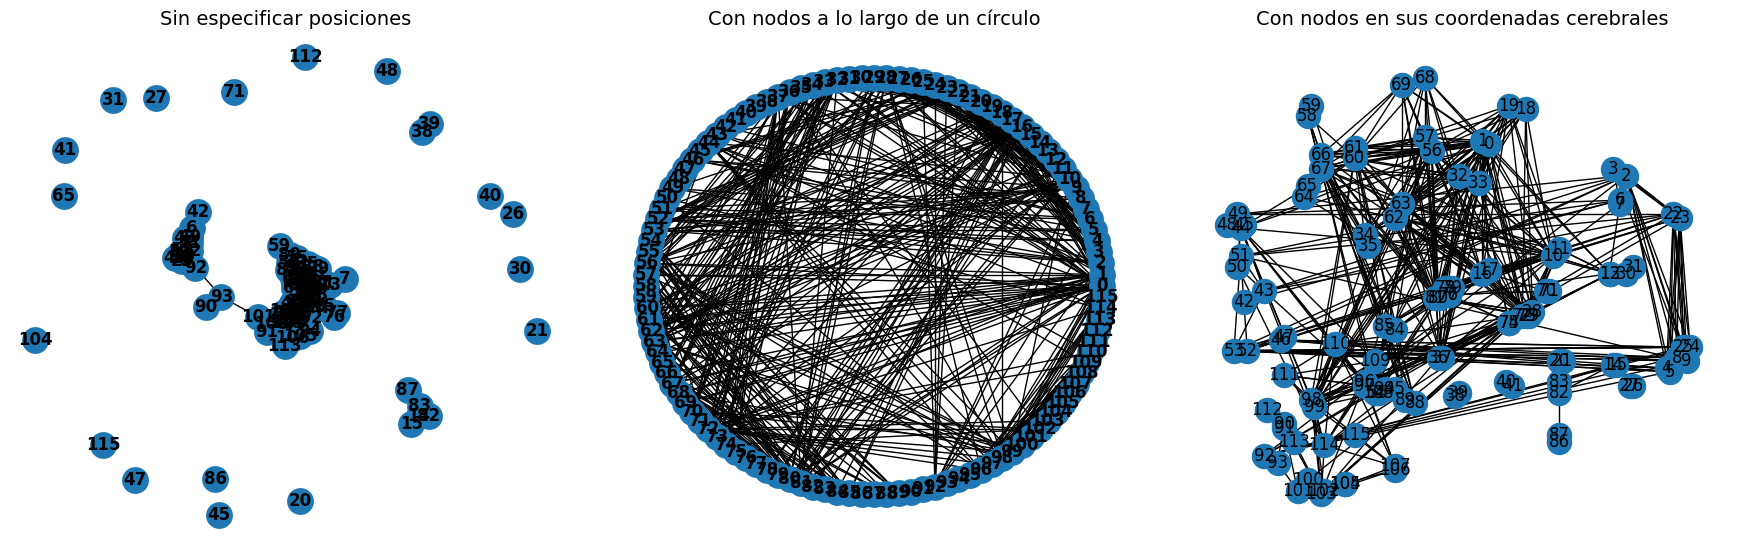

In [83]:
fig, axes = plt.subplots(1,3,figsize=(18,6))

nx.draw(G, with_labels=True, font_weight='bold', ax=axes[0])
axes[0].set_title('Sin especificar posiciones', fontsize=14)

layout=nx.circular_layout(G)
nx.draw(G,layout, with_labels=True, font_weight='bold', ax=axes[1])
axes[1].set_title('Con nodos a lo largo de un círculo', fontsize=14)

layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
nx.draw(G, layout, with_labels=True, linewidths =1, ax=axes[2])
axes[2].set_title('Con nodos en sus coordenadas cerebrales', fontsize=14)

plt.tight_layout()
plt.show()

- Visualizar el grafo, ubicando los nodos en sus coordenadas cerebrales y coloreando cada nodo de acuerdo a su coeficiente de clustering $C_{i}$

In [86]:
ci = nx.clustering(G)

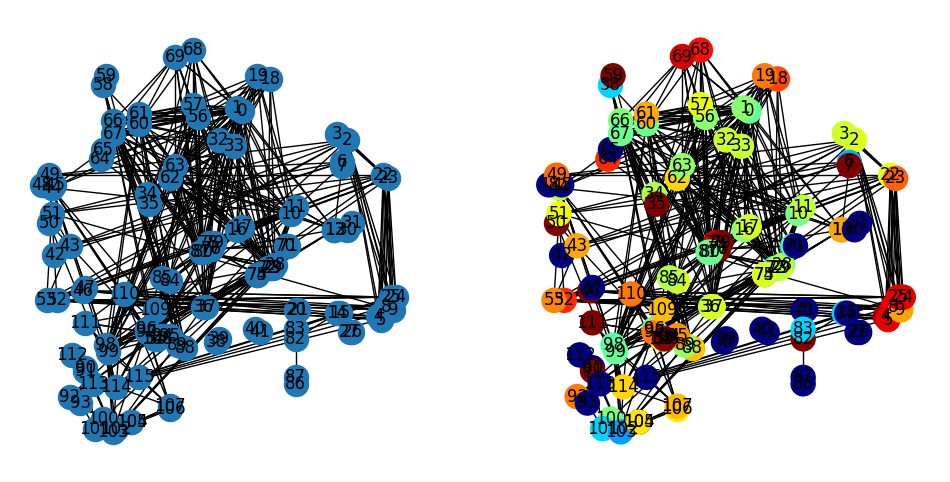

In [89]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

nx.draw(G, layout, with_labels=True, linewidths =1, ax=axes[0])

nx.draw(G, layout, with_labels=True, linewidths =1, node_color=list(ci.values()), cmap=plt.cm.jet, ax=axes[1])

- Graficar la distribución de grado del grafo, elijiendo un número de bins apropriado

- Calcular el grado promedio $< k >$, el nodo con grado máximo $k_{max}$, el coeficiente de clustering promedio $C = < C_{i} >$ y la distancia media entre pares de nodos $d$ del grafo.

- Comparar lo obtenido con prototipos de redes poissonianas, `small-World` y `scale-free`, usando los algoritmos de `Erdos-Renyi`, `Watts-Strogatz` y `Barabasi-Albert`, respectivamente. Elegir (y reportar) los parámetros utilizdos para cada algoritmo, buscando siempre que los grafos simulados sean comparables al grafo de datos $G$ (en términos de número de nodos y números de enlaces). Visualizar un ejemplo de grafo para cada uno de estos prototipos de redes. Discutir diferencias.

- Generar 1000 instancias de grafos para cada una de dichos prototipos (`poissonianas`, `small-World` y `scale-free`). Para cada prototipo, calcular el histograma de coeficientes de clustering promedio $C$ y de distancia media entre pares de nodos $d$ de cada una de las instancias, y comparar con los valor obtenido para el grafo de datos $G$.